In [1]:
import numpy as np
from pandas import read_pickle
import sklearn.cluster
import time
from wikiparse import pipeline_utils as utils

In [2]:
from pathlib import Path
from wikiparse import config

xml_filename = config.xml
scratch_folder = Path(config.folder)

In [3]:
import time
pipeline_start = time.time()

In [4]:
gdf = read_pickle(scratch_folder/'gdf.pkl')

Filter out all points outside the bounds of latitude and longitude (i.e., errors).

In [5]:
ts = time.time()
gdf['lon'] = gdf.geometry.map(lambda p: p.x)
gdf['lat'] = gdf.geometry.map(lambda p: p.y)
gdf.drop(gdf[(gdf.lat > 90) | (gdf.lon > 180) | (gdf.lat < -90) | (gdf.lon < -180)].index, 
            inplace=True)
gdf.lat.min(), gdf.lat.max(), gdf.lon.min(), gdf.lon.max()
print(time.time() - ts)

729.2138004302979


Next, let's filter out anything that's not an English word. We'll lose a lot of interesting geographic labels, but this takes us in the direction of labels that describe the region better.

In [6]:
from nltk.corpus import words
wordset = set(words.words())

In [7]:
ts = time.time()
wordcount = len(gdf)
gdf = gdf[gdf.word.map(lambda word: word in wordset)].copy()
print(f'{100*round(len(gdf)/wordcount,4)}% left after filtering out non-English words; \
        took {round(time.time()-ts,2)} seconds')

48.69% left after filtering out non-English words;         took 17.34 seconds


Use the KMeans algorithm to make clusters that we'll be able to label. I picked 193 because that's the number of member states in the UN (so, roughly a country-level cluster), 2,000 is a number vaguely chosen to be sub-state units like municipalities and territories, and 10,000 is vaguely chosen to represent the number of cities in the world.

In [8]:
partial_fit_size = min(len(gdf), 100_000)
batch_size = 100

for n_clusters in [193, 4000, 25_000]:
    start = time.time()
    # Convert DataFrame to matrix
    mat = gdf[['lat', 'lon']].values
    # Using sklearn
    km = sklearn.cluster.MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size)
    print("created model for", n_clusters)
    km = km.partial_fit(mat[np.random.choice(mat.shape[0], partial_fit_size, replace=False), :])
    km = km.partial_fit(mat[np.random.choice(mat.shape[0], partial_fit_size, replace=False), :])
    km = km.partial_fit(mat[np.random.choice(mat.shape[0], partial_fit_size, replace=False), :])

    # Format results as a DataFrame
    print(n_clusters, 'learning took', round((time.time()-start)/60, 1), 'minutes')
    
    start = time.time()
    labels = km.predict(mat)
    gdf['cluster_' + str(n_clusters)] = labels
    print('predicting took', round((time.time()-start)/60, 1), 'minutes')

created model for 193
193 learning took 0.1 minutes
predicting took 1.0 minutes
created model for 4000
4000 learning took 1.8 minutes
predicting took 11.0 minutes
created model for 25000
25000 learning took 12.2 minutes
predicting took 73.1 minutes


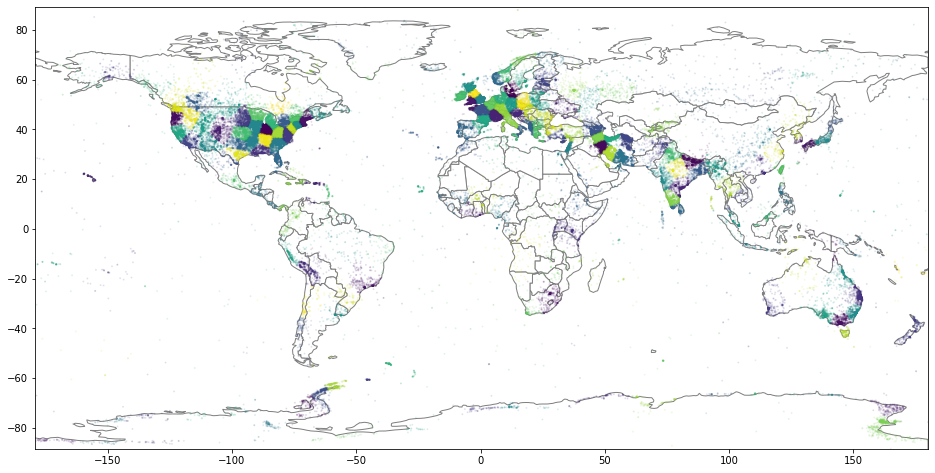

In [9]:
sample_gdf = gdf.sample(partial_fit_size)
utils.map_gdf(sample_gdf, c=sample_gdf.cluster_193, fname=scratch_folder/'clusters_193.png')

## Create continent-level clusters manually

Let's draw some rough lines around the continents so we can relabel those too.

In [10]:
def cluster_7(row, verbose=False):
    lat = row.lat
    lon = row.lon
    
    if lat < -55:
        if verbose: print("Antarctica")
        return 4
    if lon < -25:
        # N or S America
        if lat < 13:
            if verbose: print("South America")
            return 1
        if verbose: print("North America")
        return 0

    if lon > 35:
        if lat > 0:
            if lon < 60 and lat < 20:
                if verbose: print("African horn")
                return 6
            if verbose: print("Asia")
            return 2
        if lon < 70:
            if verbose: print("Africa south of equator")
            return 6
        if verbose: print("Oceania")
        return 3
    if lat > 35.8:
        if verbose: print("Europe")
        return 5
    if verbose: print("Africa")
    return 6

In [11]:
gdf['cluster_7'] = gdf.apply(cluster_7, axis=1)

In [12]:
gdf.sample(5)

,word,tf,article,df,tf_idf,geometry,lon,lat,cluster_193,cluster_4000,cluster_25000,cluster_7
23686333,rail,1,"Butler Grove Township, Montgomery County, Illi...",25226,3.96416e-05,POINT (-89.53333 39.21667),-89.533333,39.216667,89,2254,19347,0
16425040,from,3,Jagdkopf (Zorge),284974,1.05273e-05,POINT (10.60657 51.63393),10.606569,51.633931,106,1182,22017,5
4307945,northeast,1,Farewell Point,38103,2.62447e-05,POINT (-38.01667 -54.00000),-38.016667,-54.000000,125,127,59,1
26459400,clapboard,3,Oscar Blomeen House,1990,0.00150754,POINT (-122.22639 47.31111),-122.226389,47.311111,182,1924,16410,0
13601508,coast,4,Baitarani Road railway station,32751,0.000122134,POINT (86.22964 20.98359),86.229640,20.983591,55,1731,7395,2


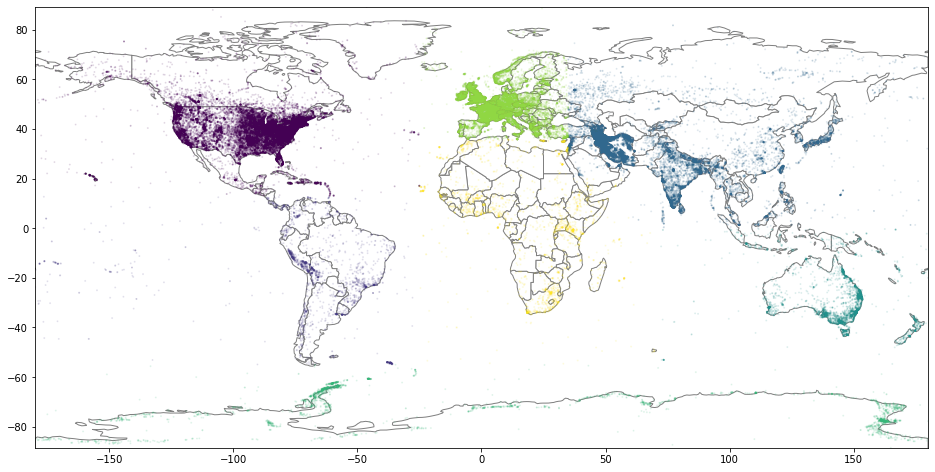

In [13]:
sample_gdf = gdf.sample(partial_fit_size)
utils.map_gdf(sample_gdf, c=sample_gdf.cluster_7, fname=scratch_folder/'clusters_7.png')

In [14]:
gdf.to_pickle(scratch_folder/'gdf_clusters.pkl')

In [15]:
took = time.time() - pipeline_start
if took < 60:
    print("pipeline took", round(took, 2), "seconds")
elif took < 3600:
    print("pipeline took", round(took/60, 2), "minutes")
else:
    print("pipeline took", round(took/60/60, 2), "hours")

pipeline took 2.31 hours
